In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import string
from collections import defaultdict

In [2]:
dirty_df = pd.read_csv('data/advanced_trainset.csv')

<AxesSubplot:>

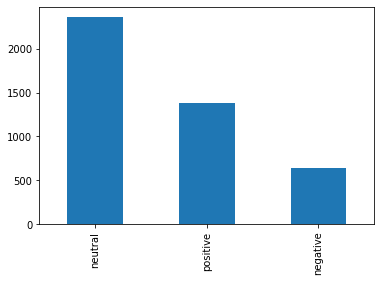

In [3]:
dirty_df.Sentiment.value_counts().plot(kind='bar')

In [36]:
def clean_sentence(s):
    # To lowercase
    s = s.lower()

    # Remove apostrophes
    s = re.sub(' \'s', '', s)

    # Fix % and $ whitespace
    s = re.sub('(?<=\d) %', '%', s)
    s = re.sub('\$ (?=\d)', '$', s)

    # Remove links
    s = re.sub('http\S+', ' ', s)

    # Remove .'s not surrounded by numbers
    s = re.sub('(?<!\d)\.|\,(?!\d)', ' ', s)

    # Remove punctuation
    s = re.sub('-|\(|\)', ' ', s)
    s = re.sub('\'|\,|\`', '', s)

    # Remove extra whitespace
    s = re.sub(' +', ' ', s)

    return s

In [37]:
df = dirty_df.copy(deep=True)
df['Sentence'] = df['Sentence'].apply(clean_sentence)
df["Sentiment"] = df['Sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
df.head()

,Sentence,Sentiment
0,according to the finnish russian chamber of co...,0
1,the swedish buyout firm has sold its remaining...,0
2,$spy wouldnt be surprised to see a green close,1
3,shells $70 billion bg deal meets shareholder s...,-1
4,ssh communications security corp stock exchang...,-1


In [8]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
# for d in df:
#     r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
#     for w in r.split():
#         wordCount[w] += 1

# counts = [(wordCount[w], w) for w in wordCount]
# counts.sort()
# counts.reverse()

In [15]:
punctuation.difference_update(['%', '$'])
punctuation

{'!',
 '"',
 '#',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}